# Zbiór danych
Zbiór danych *kredyt.csv* zawiera informacje dotyczące wniosków o kredyt hipoteczny w penym banku. Poszczególne kolumny reprezentują różne cechy związane z każdym wnioskiem:

- Loan_ID: Unikalny identyfikator każdego wniosku o kredyt.
- Gender: Płeć osoby składającej wniosek (mężczyzna/kobieta).
- Married: Status małżeński (żonaty/nie).
- Dependents: Liczba osób na utrzymaniu osoby składającej wniosek.
- Education: Poziom edukacji osoby składającej wniosek.
- Self_Employed: Czy osoba składająca wniosek jest samozatrudniona (tak/nie).
- ApplicantIncome: Dochód osoby składającej wniosek.
- CoapplicantIncome: Dochód współmałżonka lub współmałżonki osoby składającej wniosek.
- LoanAmount: Kwota kredytu hipotecznego wnioskowana przez osobę składającą wniosek.
- Loan_Amount_Term: Okres kredytowania (w miesiącach).
- Credit_History: Historia kredytowa (czy osoba składająca wniosek miała wcześniej kredyt hipoteczny, 1 - tak, 0 - nie).
- Property_Area: Lokalizacja nieruchomości (miejska/półmiejska/wiejska).
- Loan_Status: Status kredytu (zatwierdzony/niezatwierdzony).

# Zadanie
Przeprowadź eksploracyjną analizę danych zawartych w zbiorze *kredyt.csv*.
W tym celu wykonaj m.in. nastepujące kroki:
1. zaimportj potrzebne biblioteki
2. wczytaj zbiór danych
3. scharakteryzuj zbiór (kształt, rodzaj zmiennych, statystyki opisowe)
4. sprwdź, czy w zbiorze są jakieś braki, jeśli tak zadecyduj co z nimi zrobić
5. postaw minimum 3 pytania badawcze / hipotezy badawcze; pytania badawcze powinny być złożone (min. 3 zminne). Za pomocą wykresów określ, czy postawione hipotezy były słuszne czy nie. Podsumuj jakie wnioski można wyciągnąć po przeprowadzonej analizie  .
6. zbuduj model XGBoost prognozujacy status kredytu. Dostosuj hiperparametry modelu.


In [27]:
import pandas as pd
import seaborn as sns

In [42]:
df = pd.read_csv("kredyt.csv")
df.info()

df['dependents'] = df['Dependents'].astype('category').cat.codes
df['gender'] = df['Gender'].astype('category').cat.codes
df['married'] = df['Married'].astype('category').cat.codes
df['education'] = df['Education'].astype('category').cat.codes
df['self_employed'] = df['Self_Employed'].astype('category').cat.codes
df['property_area'] = df['Property_Area'].astype('category').cat.codes
df['loan_status'] = df['Loan_Status'].astype('category').cat.codes

df.pop('Gender')
df.pop('Married')
df.pop('Education')
df.pop('Self_Employed')
df.pop('Property_Area')
df.pop('Loan_Status')
df.pop('Loan_ID')
df.pop('Dependents')

df_clean = df.dropna() # Drop rows with any missing values


df_clean = df_clean[(df >= 0).all(axis=1)] # Remove rows where any column has a negative value
df_clean.pop('CoapplicantIncome')
df_clean.pop('Loan_Amount_Term')
# df_clean.pop('Credit_History')
df_clean.pop('self_employed')
df_clean.pop('dependents')

df_clean.info()
df_clean.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 480 entries, 1 to 613
Data columns (total 8 columns):
 #   Column  

<ipython-input-42-996aa8bd76a1>:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_clean = df_clean[(df >= 0).all(axis=1)] # Remove rows where any column has a negative value


,ApplicantIncome,LoanAmount,Credit_History,gender,married,education,property_area,loan_status
1,4583,128.0,1.0,1,1,0,0,0
2,3000,66.0,1.0,1,1,0,2,1
3,2583,120.0,1.0,1,1,1,2,1
4,6000,141.0,1.0,1,0,0,2,1
5,5417,267.0,1.0,1,1,0,2,1


In [43]:
X = df_clean.copy()
y = X.pop('loan_status')

print("y.value_counts() = ",y.value_counts())

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size=0.3, random_state=30)  # strtyfy - zachować stosunek 0 do 1

print("\n","y_train.value_counts() = ",y_train.value_counts())

X.describe()

y.value_counts() =  loan_status
1    332
0    148
Name: count, dtype: int64

 y_train.value_counts() =  loan_status
1    232
0    104
Name: count, dtype: int64


,ApplicantIncome,LoanAmount,Credit_History,gender,married,education,property_area
count,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000
mean,5364.231250,144.735417,0.854167,0.820833,0.647917,0.202083,1.022917
std,5668.251251,80.508164,0.353307,0.383892,0.478118,0.401973,0.776411
min,150.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2898.750000,100.000000,1.000000,1.000000,0.000000,0.000000,0.000000
50%,3859.000000,128.000000,1.000000,1.000000,1.000000,0.000000,1.000000
75%,5852.500000,170.000000,1.000000,1.000000,1.000000,0.000000,2.000000
max,81000.000000,600.000000,1.000000,1.000000,1.000000,1.000000,2.000000


In [44]:
import xgboost as xgb
from xgboost import XGBClassifier

model_xgb = XGBClassifier(n_estimators = 1000, max_depth = 10, learning_rate = 0.01)
model_xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

train: 
 [[103   1]
 [  1 231]] 

test: 
 [[26 18]
 [ 9 91]] 

train:


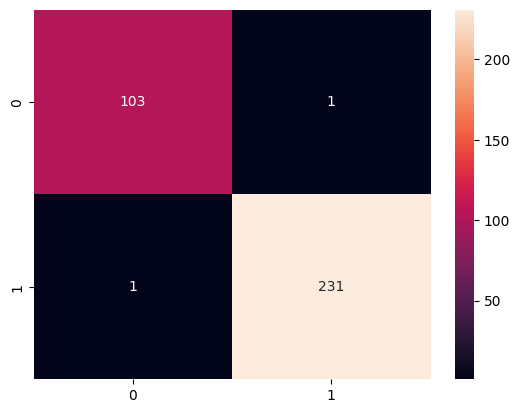


test: 


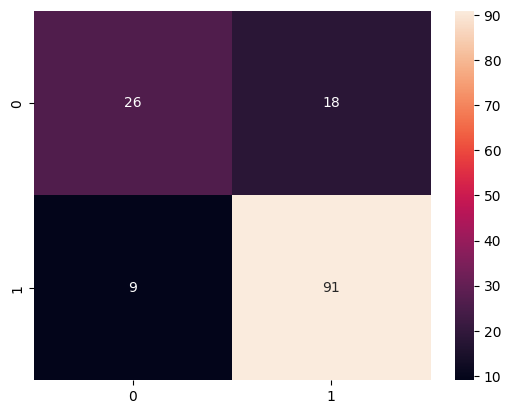


train:  
 recall:  0.9956896551724138 
 precision:  0.9956896551724138 
 f-score:  0.9956896551724138 

test:  
 recall:  0.91 
 precision:  0.8348623853211009 
 f-score:  0.8708133971291867 



In [45]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

y_pred_train = model_xgb.predict(X_train)
y_pred_test = model_xgb.predict(X_test)

print("train: \n",confusion_matrix(y_train, y_pred_train),"\n")
print("test: \n",confusion_matrix(y_test, y_pred_test),"\n")


print("train:")
conf_matrix = confusion_matrix(y_train, y_pred_train)
sns.heatmap(conf_matrix, annot = True, fmt ='d')
plt.show()
print()

print("test: ")
conf_matrix = confusion_matrix(y_test, y_pred_test)
sns.heatmap(conf_matrix, annot = True, fmt ='d')
plt.show()
print()


print('train: ', '\n',
    'recall: ', recall_score(y_train, y_pred_train), '\n',
     'precision: ', precision_score(y_train, y_pred_train), '\n',
     'f-score: ', f1_score(y_train, y_pred_train), '\n')


print('test: ', '\n',
    'recall: ', recall_score(y_test, y_pred_test), '\n',
     'precision: ', precision_score(y_test, y_pred_test), '\n',
     'f-score: ', f1_score(y_test, y_pred_test), '\n')